In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

In [116]:
df = pd.read_csv("hurt.csv")
df.head()

,Unnamed: 0,file_id,user_id,subforum_id,num_contexts,label,text_data
0,0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


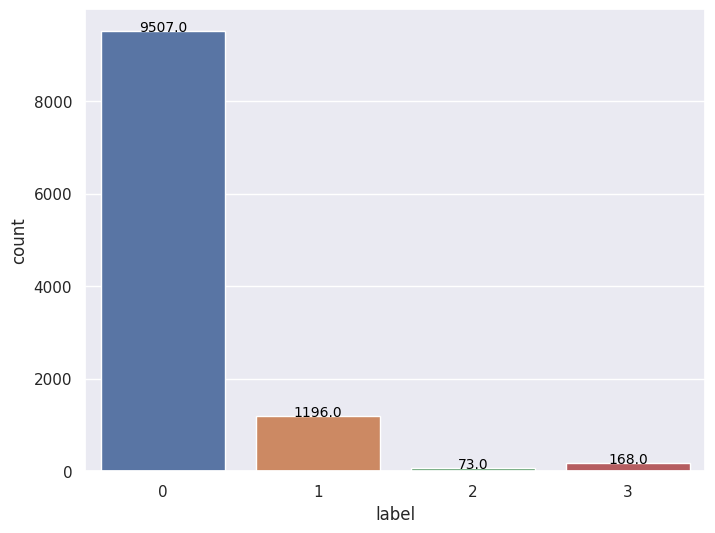

In [30]:
#Frequency of Labels
sns.set()
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Create a count plot
ax = sns.countplot(x="label", data=df)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black')

plt.show()

In [117]:
display(df.groupby('label').describe())
#0 - noHate
#1 - hate
#2 - idk/Skip
#3 - relation

# Replace values in a specific column
replacement = {'noHate': 0, 'hate': 1, 'idk/skip': 2, 'relation': 3}
df['label'].replace(replacement, inplace=True)
display(df.groupby('label').describe())

Unnamed: 0                                                            \
              count         mean          std    min      25%     50%     75%   
label                                                                           
hate         1196.0  5170.297659  3184.753063    3.0  2437.50  4856.0  7905.5   
idk/skip       73.0  5820.054795  3353.104784  254.0  3786.00  5569.0  9793.0   
noHate       9507.0  5492.637215  3153.854842    0.0  2778.50  5514.0  8213.5   
relation      168.0  6268.178571  3015.680847  438.0  3557.75  6693.5  8966.0   

                  user_id                 ... subforum_id          \
              max   count           mean  ...         75%     max   
label                                     ...                       
hate      10942.0  1196.0  587276.589465  ...      1387.0  1397.0   
idk/skip  10817.0    73.0  578709.095890  ...      1393.0  1397.0   
noHate    10943.0  9507.0  586524.176291  ...      1387.0  1397.0   
relation  10474.0   168.0  581562.589286  ...      1387.0  1396.0   

         num_contexts                                                
                count      mean       std  min  25%  50%  75%   max  
label                                                                
hate           1196.0  0.598662  1.839901  0.0  0.0  0.0  0.0  22.0  
idk/skip         73.0  0.027397  0.164368  0.0  0.0  0.0  0.0   1.0  
noHate         9507.0  0.184706  0.991742  0.0  0.0  0.0  0.0  32.0  
relation        168.0  0.214286  1.056164  0.0  0.0  0.0  0.0   8.0  

[4 rows x 32 columns]

/tmp/ipykernel_34/4150336665.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace(replacement, inplace=True)
/tmp/ipykernel_34/4150336665.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'].replace(replacement, inplace=True)


Unnamed: 0                                                            \
           count         mean          std    min      25%     50%     75%   
label                                                                        
0         9507.0  5492.637215  3153.854842    0.0  2778.50  5514.0  8213.5   
1         1196.0  5170.297659  3184.753063    3.0  2437.50  4856.0  7905.5   
2           73.0  5820.054795  3353.104784  254.0  3786.00  5569.0  9793.0   
3          168.0  6268.178571  3015.680847  438.0  3557.75  6693.5  8966.0   

               user_id                 ... subforum_id         num_contexts  \
           max   count           mean  ...         75%     max        count   
label                                  ...                                    
0      10943.0  9507.0  586524.176291  ...      1387.0  1397.0       9507.0   
1      10942.0  1196.0  587276.589465  ...      1387.0  1397.0       1196.0   
2      10817.0    73.0  578709.095890  ...      1393.0  1397.0         73.0   
3      10474.0   168.0  581562.589286  ...      1387.0  1396.0        168.0   

                                                     
           mean       std  min  25%  50%  75%   max  
label                                                
0      0.184706  0.991742  0.0  0.0  0.0  0.0  32.0  
1      0.598662  1.839901  0.0  0.0  0.0  0.0  22.0  
2      0.027397  0.164368  0.0  0.0  0.0  0.0   1.0  
3      0.214286  1.056164  0.0  0.0  0.0  0.0   8.0  

[4 rows x 32 columns]

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

def preprocess_text(text):
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    preprocessed_text = ' '.join(stemmed_tokens)
    
    return preprocessed_text

df["text_data"] = df["text_data"].apply(lambda x : preprocess_text(x))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text_data'],df['label'], stratify=df['label'])

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [11]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [12]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.25, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(4, activation='softmax', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/15
  1/257 [..............................] - ETA: 49:53 - loss: 2.1406 - accuracy: 0.0000e+00

I0000 00:00:1709388441.069765      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


257/257 [==============================] - 117s 411ms/step - loss: 0.5107 - accuracy: 0.8566 - val_loss: 0.4580 - val_accuracy: 0.8688
Epoch 2/15
257/257 [==============================] - 109s 424ms/step - loss: 0.4562 - accuracy: 0.8665 - val_loss: 0.4292 - val_accuracy: 0.8688
Epoch 3/15
257/257 [==============================] - 110s 428ms/step - loss: 0.4473 - accuracy: 0.8660 - val_loss: 0.4241 - val_accuracy: 0.8688
Epoch 4/15
257/257 [==============================] - 110s 428ms/step - loss: 0.4399 - accuracy: 0.8661 - val_loss: 0.4130 - val_accuracy: 0.8695
Epoch 5/15
257/257 [==============================] - 110s 428ms/step - loss: 0.4357 - accuracy: 0.8654 - val_loss: 0.4067 - val_accuracy: 0.8692
Epoch 6/15
257/257 [==============================] - 110s 427ms/step - loss: 0.4239 - accuracy: 0.8672 - val_loss: 0.4220 - val_accuracy: 0.8688
Epoch 7/15
257/257 [==============================] - 109s 426ms/step - loss: 0.4256 - accuracy: 0.8676 - val_loss: 0.4136 - val_accura

In [14]:
model.save("/kaggle/working/NLP-bert.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


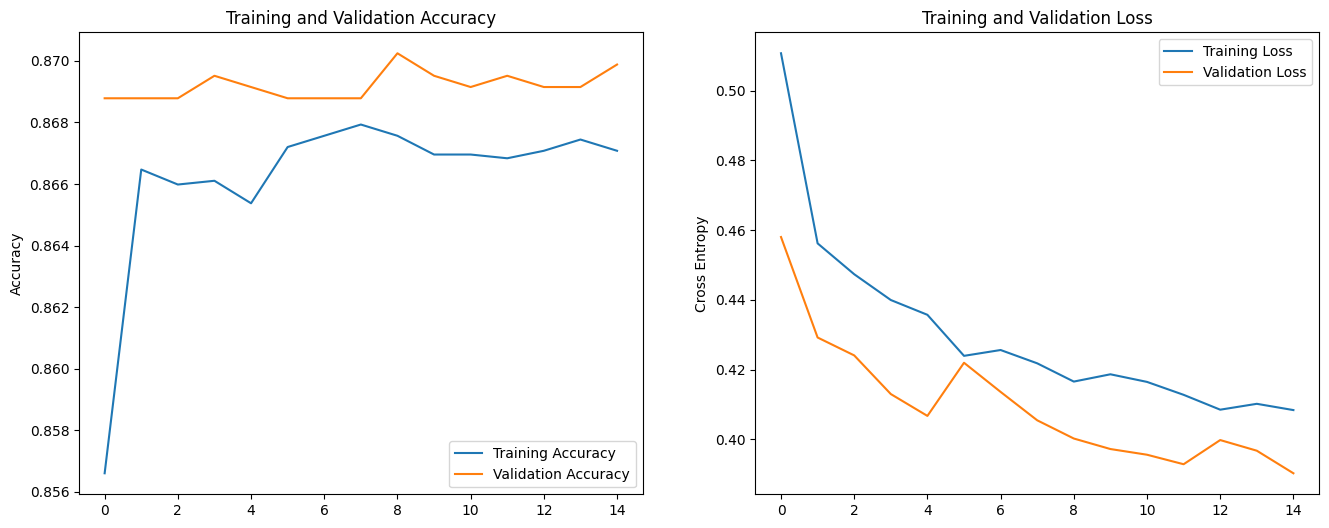

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Training and Validation Accuracy

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

#Training and Validation Loss

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.2f}%")
print(f"Test Accuracy: {accuracy:.2f}%")


86/86 [==============================] - 27s 318ms/step - loss: 0.3903 - accuracy: 0.8699
Test Loss: 0.39%
Test Accuracy: 0.87%


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
y_true_labels = tf.argmax(y_test, axis=1).numpy()

86/86 [==============================] - 28s 317ms/step


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))

Accuracy: 0.8698830409356725

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      2377
           1       0.50      0.03      0.05       299
           2       1.00      0.11      0.20        18
           3       0.00      0.00      0.00        42

    accuracy                           0.87      2736
   macro avg       0.59      0.28      0.30      2736
weighted avg       0.82      0.87      0.82      2736

Confusion Matrix:
 [[2370    7    0    0]
 [ 291    8    0    0]
 [  16    0    2    0]
 [  41    1    0    0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


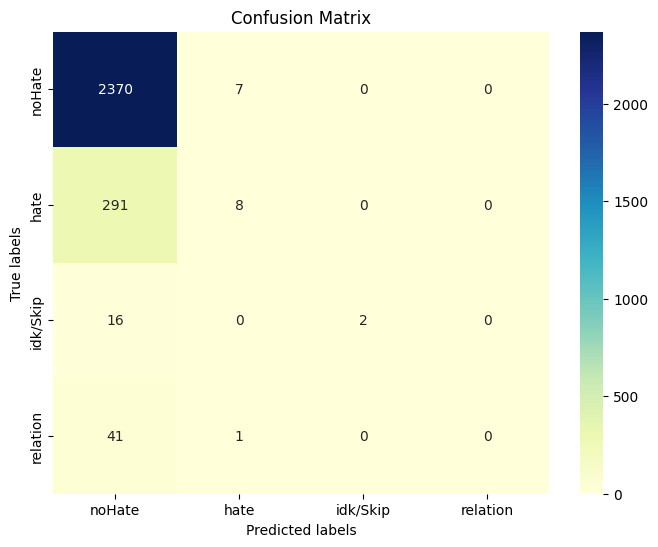

In [19]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=['noHate', 'hate', 'idk/Skip', 'relation'], 
            yticklabels=['noHate', 'hate', 'idk/Skip', 'relation'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#0 - noHate
#1 - hate
#2 - idk/Skip
#3 - relation

# Due to an imbalance in the dataset, the model did not predict accurately. So we Have to reduce the data set size

In [126]:
df_nohate = df[df['label'] == 0]
df_hate = df[df['label'] == 1]
df_idk = df[df['label'] == 2]
df_rel = df[df['label'] == 3]

df_hate = df_hate.sample(df_hate.shape[0])
df_nohate = df_nohate.sample(df_hate.shape[0])

df2 = pd.concat([df_hate, df_nohate])
df2["label"].value_counts()

df2["text_data"] = df2["text_data"].apply(lambda x : preprocess_text(x))

In [127]:
df2

,Unnamed: 0,file_id,user_id,subforum_id,num_contexts,label,text_data
8738,8738,31757290_2,574608,1363,0,1,simpl want creat white guilt
9182,9182,14088896_3,573561,1381,0,1,tri find job mexican take everyth
9046,9046,13855831_1,584865,1391,0,1,anoth coon give ireland opinion count second g...
6992,6992,14023144_1,573375,1387,0,1,stop get dead pig buri underground mosqu built
861,861,30546994_1,573410,1348,1,1,essenti childlik someon step say someth carri ...
...,...,...,...,...,...,...,...
2448,2448,13589166_1,586425,1393,0,0,shall wast singl moment time convers
1584,1584,14060016_3,575123,1383,0,0,bet knew exactli let appear televis creat bigg...
4349,4349,31749725_1,573589,1363,0,0,damn least sound plausabl stupid sea mayb look...
1015,1015,30712848_3,572744,1354,0,0,heroin


In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df2['text_data'],df2['label'], stratify=df2['label'])

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [131]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model2 = tf.keras.Model(inputs=[text_input], outputs = [l])
model2.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/15
57/57 [==============================] - 26s 428ms/step - loss: 0.5939 - accuracy: 0.6784 - val_loss: 0.5485 - val_accuracy: 0.7124
Epoch 2/15
57/57 [==============================] - 23s 406ms/step - loss: 0.5901 - accuracy: 0.6901 - val_loss: 0.5765 - val_accuracy: 0.6856
Epoch 3/15
57/57 [==============================] - 23s 410ms/step - loss: 0.5792 - accuracy: 0.6973 - val_loss: 0.5564 - val_accuracy: 0.7207
Epoch 4/15
57/57 [==============================] - 24s 422ms/step - loss: 0.5805 - accuracy: 0.6984 - val_loss: 0.5556 - val_accuracy: 0.7157


In [133]:
model2.save("/kaggle/working/NLP-bert-2.h5")

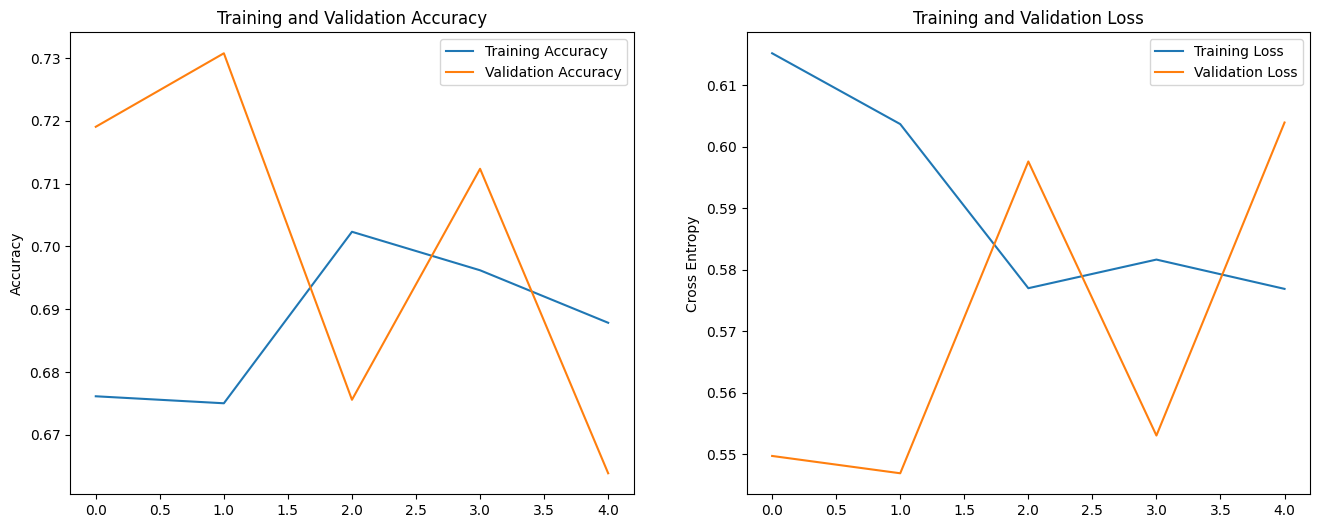

In [24]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

#Training and Validation Accuracy

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

#Training and Validation Loss

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.2f}%")
print(f"Test Accuracy: {accuracy:.2f}%")


19/19 [==============================] - 6s 301ms/step - loss: 0.5469 - accuracy: 0.7308
Test Loss: 0.55%
Test Accuracy: 0.73%


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
y_true_labels = tf.argmax(y_test, axis=1).numpy()

19/19 [==============================] - 6s 307ms/step


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))

Accuracy: 0.7307692307692307

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73       299
           1       0.72      0.75      0.74       299

    accuracy                           0.73       598
   macro avg       0.73      0.73      0.73       598
weighted avg       0.73      0.73      0.73       598

Confusion Matrix:
 [[213  86]
 [ 75 224]]


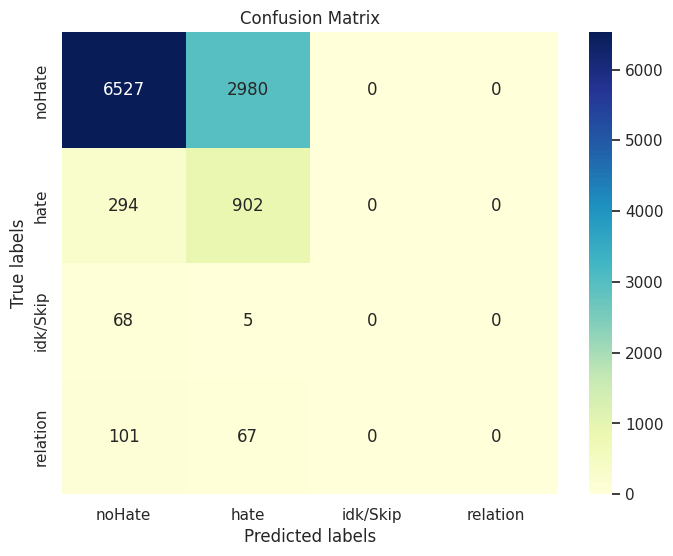

In [53]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=['noHate', 'hate', 'idk/Skip', 'relation'], 
            yticklabels=['noHate', 'hate', 'idk/Skip', 'relation'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#0 - noHate
#1 - hate
#2 - idk/Skip
#3 - relation

In [49]:
y_pred = model.predict(df["text_data"])

y_pred_labels = tf.argmax(y_pred, axis=1).numpy()

342/342 [==============================] - 108s 316ms/step


In [50]:
y_new = tf.keras.utils.to_categorical(df["label"], num_classes=4)

y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
y_true_labels = tf.argmax(y_new, axis=1).numpy()

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))

Accuracy: 0.6788194444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      9507
           1       0.23      0.75      0.35      1196
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       168

    accuracy                           0.68     10944
   macro avg       0.29      0.36      0.29     10944
weighted avg       0.84      0.68      0.73     10944

Confusion Matrix:
 [[6527 2980    0    0]
 [ 294  902    0    0]
 [  68    5    0    0]
 [ 101   67    0    0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


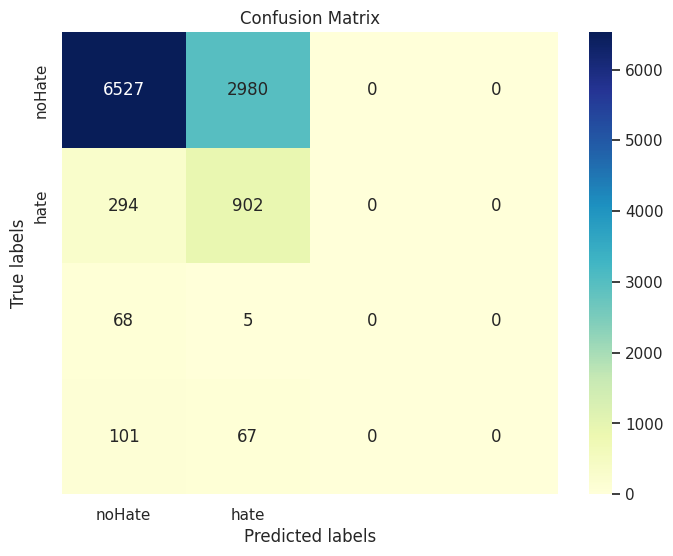

In [52]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=['noHate', 'hate'], 
            yticklabels=['noHate', 'hate'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#0 - noHate
#1 - hate
#2 - idk/Skip
#3 - relation

# Lets try with different Models

In [122]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [124]:
# CountVectorizer
vec = CountVectorizer(lowercase=True,stop_words="english")
vec.fit(df["text_data"])
vect = vec.transform(df["text_data"])
df1 = pd.DataFrame(vect.toarray(), columns=vec.get_feature_names_out())

# TfidfVectorizer
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1,1), stop_words='english')
tf_smooth = tfidf.fit_transform(df["text_data"])
df2 = pd.DataFrame(tf_smooth.toarray(), columns=tfidf.get_feature_names_out())

df2["label"] = df["label"]

X = df2.drop("label",axis=1)
y = df2.label

In [76]:
#train and test for new models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [103]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, confusion_matrix,classification_report

def Prediction_with_report(y_pred):
    ac = accuracy_score(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy Score is {ac:.2f}")
    print(cm,"\n")
    
    f1 = f1_score(y_test, y_pred,average='macro')
    print("F1 Score:", f1)
    
    print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", 
                xticklabels=['noHate', 'hate', 'idk/Skip', 'relation'], 
                yticklabels=['noHate', 'hate', 'idk/Skip', 'relation'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy Score is 0.57
[[1147  616   47   99]
 [ 129   98    0    7]
 [   3    0    9    0]
 [  14   17    0    3]] 

F1 Score: 0.3065499913951316

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      9507
           1       0.23      0.75      0.35      1196
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       168

    accuracy                           0.68     10944
   macro avg       0.29      0.36      0.29     10944
weighted avg       0.84      0.68      0.73     10944



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


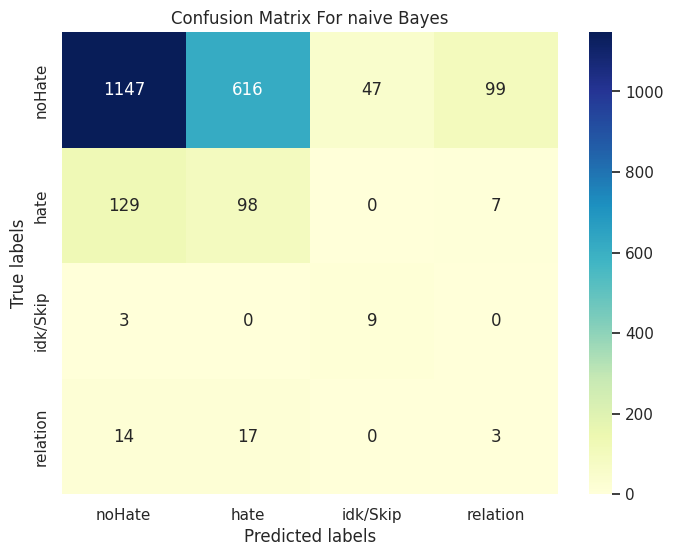

In [92]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predicting the Test set results
y_pred_naive = nb.predict(X_test)

Prediction_with_report(y_pred_naive)

Accuracy Score is 0.85
[[1771  119    0   19]
 [ 143   89    0    2]
 [   8    1    3    0]
 [  26    4    0    4]] 

F1 Score: 0.46303345492416725

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      9507
           1       0.23      0.75      0.35      1196
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       168

    accuracy                           0.68     10944
   macro avg       0.29      0.36      0.29     10944
weighted avg       0.84      0.68      0.73     10944



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


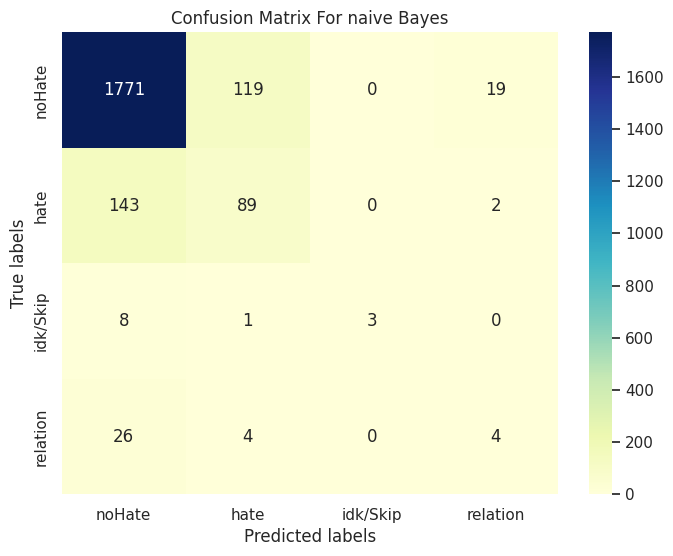

In [94]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

# Predicting the Test set results
y_pred_dt= dt.predict(X_test)

Prediction_with_report(y_pred_dt)

Accuracy Score is 0.88
[[1897   11    0    1]
 [ 201   32    0    1]
 [   9    0    3    0]
 [  33    0    0    1]] 

F1 Score: 0.40553061806221424

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      9507
           1       0.23      0.75      0.35      1196
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       168

    accuracy                           0.68     10944
   macro avg       0.29      0.36      0.29     10944
weighted avg       0.84      0.68      0.73     10944



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


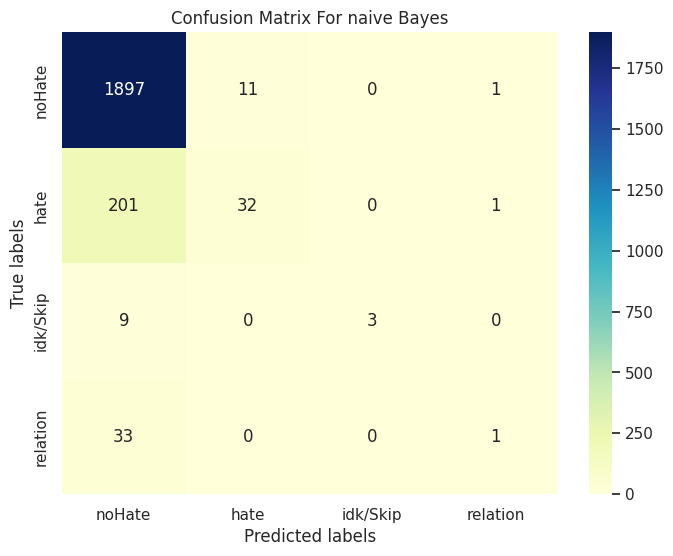

In [96]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
rfc.fit(X_train, y_train)

y_pred_forest = rfc.predict(X_test)

Prediction_with_report(y_pred_forest)

Accuracy Score is 0.88
[[1900    8    0    1]
 [ 211   22    0    1]
 [   9    0    3    0]
 [  34    0    0    0]] 

F1 Score: 0.3754840429895808

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      9507
           1       0.23      0.75      0.35      1196
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       168

    accuracy                           0.68     10944
   macro avg       0.29      0.36      0.29     10944
weighted avg       0.84      0.68      0.73     10944



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


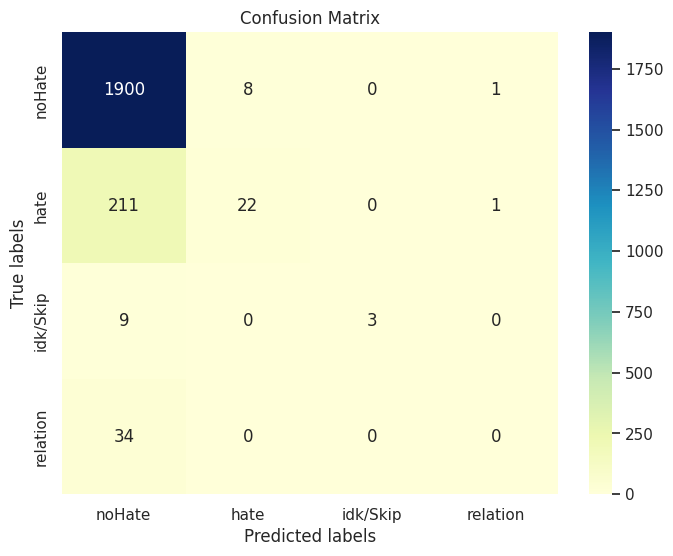

In [104]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
gb_clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, random_state=42)
gb_clf.fit(X_train, y_train)

y_pred_gb = gb_clf.predict(X_test)
Prediction_with_report(y_pred_gb)


Accuracy Score is 0.87
[[1909    0    0    0]
 [ 234    0    0    0]
 [  12    0    0    0]
 [  34    0    0    0]] 

F1 Score: 0.23291849682772087

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      9507
           1       0.23      0.75      0.35      1196
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       168

    accuracy                           0.68     10944
   macro avg       0.29      0.36      0.29     10944
weighted avg       0.84      0.68      0.73     10944



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


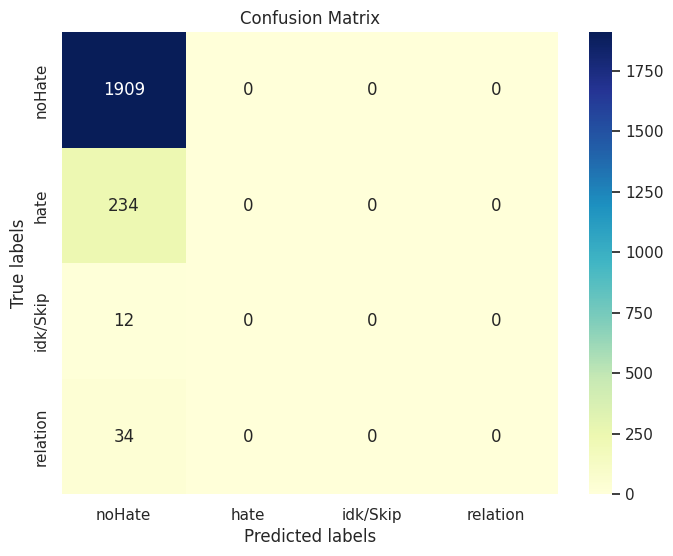

In [105]:
adaboost_clf = AdaBoostClassifier(n_estimators=500, learning_rate=0.01, random_state=42)
adaboost_clf.fit(X_train, y_train)

y_pred_ad = adaboost_clf.predict(X_test)
Prediction_with_report(y_pred_ad)

In [106]:
!pip install -q catboost    

Accuracy Score is 0.87
[[1905    4    0    0]
 [ 226    8    0    0]
 [  12    0    0    0]
 [  34    0    0    0]] 

F1 Score: 0.24937323161777872

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      9507
           1       0.23      0.75      0.35      1196
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       168

    accuracy                           0.68     10944
   macro avg       0.29      0.36      0.29     10944
weighted avg       0.84      0.68      0.73     10944



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


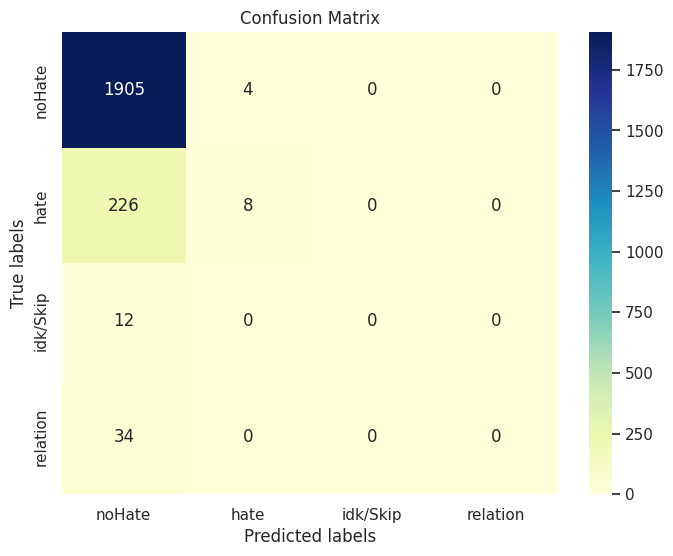

In [107]:
from catboost import CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.01, random_state=42, verbose=0)
catboost_clf.fit(X_train, y_train)

y_pred_ct = catboost_clf.predict(X_test)
Prediction_with_report(y_pred_ct)

In [108]:
!pip install -q xgboost

Accuracy Score is 0.88
[[1865   43    1    0]
 [ 178   55    0    1]
 [   9    0    3    0]
 [  32    2    0    0]] 

F1 Score: 0.4096190132882245

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      9507
           1       0.23      0.75      0.35      1196
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       168

    accuracy                           0.68     10944
   macro avg       0.29      0.36      0.29     10944
weighted avg       0.84      0.68      0.73     10944



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


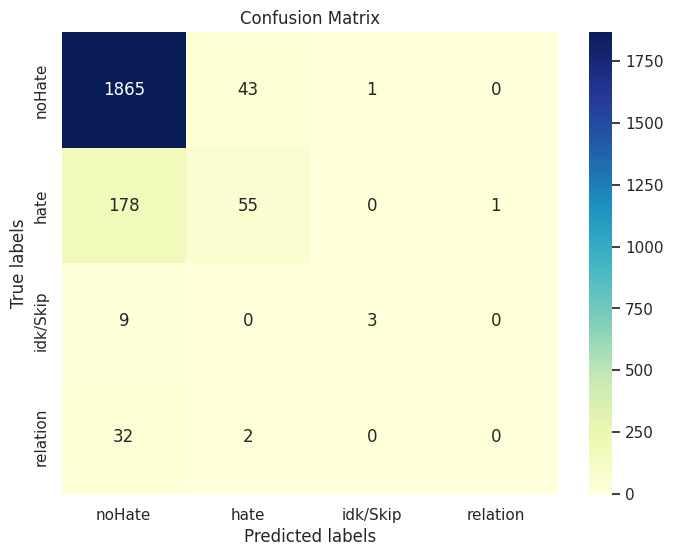

In [109]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 20,
    'eta': 0.1,
    'objective': 'multi:softmax',  
    'eval_metric': 'merror', 
    'num_class': 4
}

num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

y_pred = xgb_model.predict(dtest)
predictions = [round(value) for value in y_pred]

Prediction_with_report(predictions)